<a href="https://colab.research.google.com/github/avirooppal/Differential-Privacy-in-Federated-Learning/blob/main/Federated_Learning_with_Differential_Privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install numpy matplotlib

Scenario-
Two IoT devices (e.g., GPS trackers) collect 2D location data (latitude, longitude). They want to collaboratively build a global model (e.g., average location), without exposing their private data.

How It Works-
Data Simulation: Each device generates 100 samples of 2D location data.
Local Training: Devices compute the mean of their local data.
Differential Privacy: Laplace noise is added to each local update.
Global Aggregation: The server averages the noisy updates to produce a global model.

Key Points-
Protects privacy using the Laplace Mechanism.
Enables decentralized collaboration without sharing raw data.


Devices: 2
True Global Mean: [0.49562385 0.49415505]
DP Global Mean  : [0.66798576 0.13218452]
Error (L2 norm) : 0.4009130738007136

Devices: 5
True Global Mean: [0.48130526 0.51663662]
DP Global Mean  : [0.30877828 0.42250559]
Error (L2 norm) : 0.19653552257010717

Devices: 10
True Global Mean: [0.50027397 0.49768103]
DP Global Mean  : [0.36901432 0.79632105]
Error (L2 norm) : 0.32621306129493655

Devices: 20
True Global Mean: [0.49528607 0.4917847 ]
DP Global Mean  : [0.59924901 0.3824297 ]
Error (L2 norm) : 0.15088674051236656

Devices: 50
True Global Mean: [0.5019951  0.49783039]
DP Global Mean  : [0.4620374  0.56900904]
Error (L2 norm) : 0.08162731149816871

Devices: 100
True Global Mean: [0.50013106 0.50187032]
DP Global Mean  : [0.48696966 0.32696567]
Error (L2 norm) : 0.17539914618098787


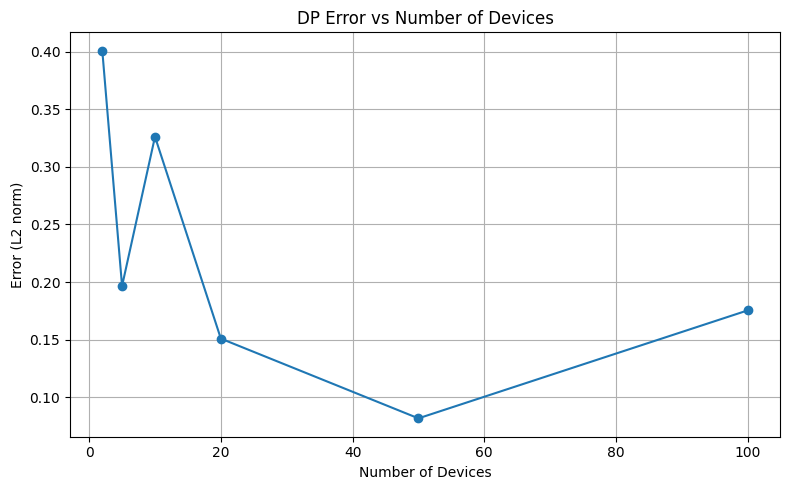

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def generate_device_data(n_samples=100):
    return np.random.rand(n_samples, 2)

def local_train(data):
    return np.mean(data, axis=0)

def add_dp_noise(update, epsilon=1.0, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale, size=update.shape)
    return update + noise

device_counts = [2, 5, 10, 20, 50, 100]
errors = []

for num_devices in device_counts:
    updates = []
    dp_updates = []

    for _ in range(num_devices):
        data = generate_device_data()
        local_update = local_train(data)
        dp_update = add_dp_noise(local_update, epsilon=1.0)
        updates.append(local_update)
        dp_updates.append(dp_update)

    true_global = np.mean(updates, axis=0)
    dp_global = np.mean(dp_updates, axis=0)

    error = np.linalg.norm(dp_global - true_global)
    errors.append(error)

    print(f"\nDevices: {num_devices}")
    print("True Global Mean:", true_global)
    print("DP Global Mean  :", dp_global)
    print("Error (L2 norm) :", error)


plt.figure(figsize=(8, 5))
plt.plot(device_counts, errors, marker='o')
plt.title("DP Error vs Number of Devices")
plt.xlabel("Number of Devices")
plt.ylabel("Error (L2 norm)")
plt.grid(True)
plt.tight_layout()
plt.show()

Federated Learning with DP for N Users —
This uses:

MNIST

Simulated FL with any number of clients

Manual DP (gradient clipping + Gaussian noise)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:

torch.manual_seed(42)
np.random.seed(42)

In [3]:
NUM_USERS = 10          # Number of clients
BATCH_SIZE = 32         # Batch size for local training
ROUNDS = 20             # Communication rounds
EPOCHS_PER_USER = 1     # Local epochs
CLIP = 1.0              # Gradient clipping norm
LR = 0.1                # Learning rate

In [4]:
# Different privacy levels to test (noise multipliers)
NOISE_LEVELS = [0.0, 0.1, 0.5, 1.0, 2.0]

In [5]:
transform = transforms.ToTensor()
train_data = datasets.MNIST('.', train=True, download=True, transform=transform)
test_data = datasets.MNIST('.', train=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=128)

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.08MB/s]


In [6]:
def split_data(dataset, num_users):
    num_items = len(dataset) // num_users
    user_data = []
    indices = np.arange(len(dataset))

    # Create non-IID split by sorting labels first
    labels = np.array([dataset[i][1] for i in range(len(dataset))])
    sorted_indices = np.argsort(labels)

    for i in range(num_users):
        start_idx = i * num_items
        end_idx = (i+1) * num_items if i != num_users-1 else len(dataset)
        user_indices = sorted_indices[start_idx:end_idx]
        user_data.append(Subset(dataset, user_indices))
    return user_data

user_datasets = split_data(train_data, NUM_USERS)

In [7]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        return self.fc(x.view(-1, 784))

In [8]:
def train_with_dp(model, data, noise=0.0):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=LR)
    loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

    for _ in range(EPOCHS_PER_USER):
        for x, y in loader:
            optimizer.zero_grad()
            output = model(x)
            loss = nn.functional.cross_entropy(output, y)
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)

            # Add noise for DP
            for p in model.parameters():
                p.grad += torch.randn_like(p.grad) * noise * CLIP

            optimizer.step()
    return model.state_dict()

In [9]:
def test(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            correct += (output.argmax(1) == y).sum().item()
    return correct / len(test_data)

# Main FL+DP experiment
results = {}

In [10]:
for noise in NOISE_LEVELS:
    print(f"\n=== Training with noise={noise} ===")
    global_model = MNIST_Net()
    accuracies = []

    for round in range(ROUNDS):
        # Local training on each user's data
        user_models = []
        for user_idx, user_data in enumerate(user_datasets):
            local_model = copy.deepcopy(global_model)
            user_state = train_with_dp(local_model, user_data, noise)
            user_models.append(user_state)

        # Federated averaging
        global_state = {}
        for key in user_models[0].keys():
            global_state[key] = torch.stack([m[key] for m in user_models]).mean(0)

        global_model.load_state_dict(global_state)

        # Evaluate
        acc = test(global_model)
        accuracies.append(acc)
        print(f"Round {round+1}/{ROUNDS} | Accuracy: {acc:.4f}")

    results[noise] = accuracies


=== Training with noise=0.0 ===
Round 1/20 | Accuracy: 0.4234
Round 2/20 | Accuracy: 0.4569
Round 3/20 | Accuracy: 0.4903
Round 4/20 | Accuracy: 0.5169
Round 5/20 | Accuracy: 0.5474
Round 6/20 | Accuracy: 0.5761
Round 7/20 | Accuracy: 0.6043
Round 8/20 | Accuracy: 0.6270
Round 9/20 | Accuracy: 0.6494
Round 10/20 | Accuracy: 0.6680
Round 11/20 | Accuracy: 0.6811
Round 12/20 | Accuracy: 0.6949
Round 13/20 | Accuracy: 0.7059
Round 14/20 | Accuracy: 0.7167
Round 15/20 | Accuracy: 0.7261
Round 16/20 | Accuracy: 0.7339
Round 17/20 | Accuracy: 0.7420
Round 18/20 | Accuracy: 0.7468
Round 19/20 | Accuracy: 0.7539
Round 20/20 | Accuracy: 0.7592

=== Training with noise=0.1 ===
Round 1/20 | Accuracy: 0.4063
Round 2/20 | Accuracy: 0.4595
Round 3/20 | Accuracy: 0.5033
Round 4/20 | Accuracy: 0.5280
Round 5/20 | Accuracy: 0.5634
Round 6/20 | Accuracy: 0.6048
Round 7/20 | Accuracy: 0.6092
Round 8/20 | Accuracy: 0.6095
Round 9/20 | Accuracy: 0.6136
Round 10/20 | Accuracy: 0.6245
Round 11/20 | Accuracy

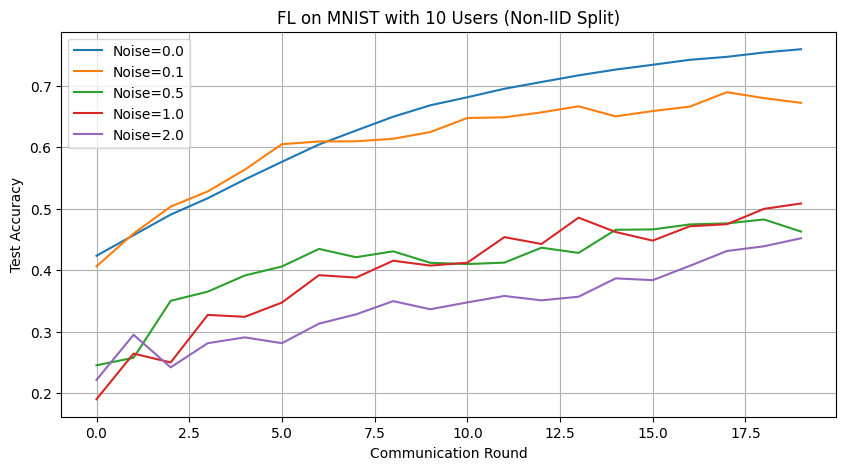

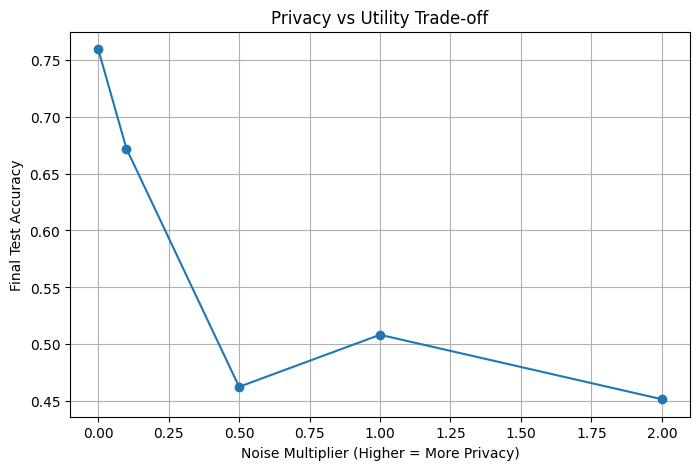

In [11]:
# Plot training progress
plt.figure(figsize=(10,5))
for noise, accs in results.items():
    plt.plot(accs, label=f'Noise={noise}')
plt.title(f"FL on MNIST with {NUM_USERS} Users (Non-IID Split)")
plt.xlabel("Communication Round")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid()
plt.show()

# Plot privacy-utility trade-off
final_accs = {noise: accs[-1] for noise, accs in results.items()}
plt.figure(figsize=(8,5))
plt.plot(list(final_accs.keys()), list(final_accs.values()), 'o-')
plt.title("Privacy vs Utility Trade-off")
plt.xlabel("Noise Multiplier (Higher = More Privacy)")
plt.ylabel("Final Test Accuracy")
plt.grid()
plt.show()

In [12]:
print("\nFinal Accuracies for Each Noise Level:")
print("{:<10} {:<15}".format("Noise", "Accuracy"))
for noise, acc in final_accs.items():
    print("{:<10} {:<15.4f}".format(noise, acc))


Final Accuracies for Each Noise Level:
Noise      Accuracy       
0.0        0.7592         
0.1        0.6720         
0.5        0.4627         
1.0        0.5084         
2.0        0.4518         
